### Load Data

In [1]:
import os
path = r'C:\Users\nadda\Desktop\KU\01204314-65-Statistics-for-Computer-Engineering-Applications\week10'
data_path = os.path.join(path, "data")
infra_path = os.path.join(data_path, r"timeseries\infrastructure")
econ_path = os.path.join(data_path, r"timeseries\econ")
pop_path = os.path.join(data_path, r"timeseries\population")
processed_data_path = os.path.join(path, "processed_data")
os.chdir(path)
os.getcwd()

'C:\\Users\\nadda\\Desktop\\KU\\01204314-65-Statistics-for-Computer-Engineering-Applications\\week10'

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import seaborn as sns
from pandas.plotting import scatter_matrix
from statsmodels.tsa.api import SimpleExpSmoothing

In [3]:
# Mapping between region and country
df_regions = pd.read_excel(os.path.join(data_path, "countries_regions.xlsx"))
df_regions.reset_index(inplace=True)

df_electricity = pd.read_csv(os.path.join(infra_path, "EG.ELC.ACCS.ZS_ts.csv"))
df_internet = pd.read_csv(os.path.join(infra_path, "IT.NET.BBND.P2_ts.csv"))
df_hospital = pd.read_csv(os.path.join(infra_path, "SH.MED.BEDS.ZS_ts.csv"))

df_gdp = pd.read_csv(os.path.join(econ_path, "NY.GDP.MKTP.CD_ts.csv"))
df_pop_working_age = pd.read_csv(os.path.join(pop_path, "SP.POP.1564.TO.ZS_ts.csv"))
df_life_expectancy = pd.read_csv(os.path.join(pop_path, "SP.DYN.LE00.IN_ts.csv"))

### Clean

<Axes: >

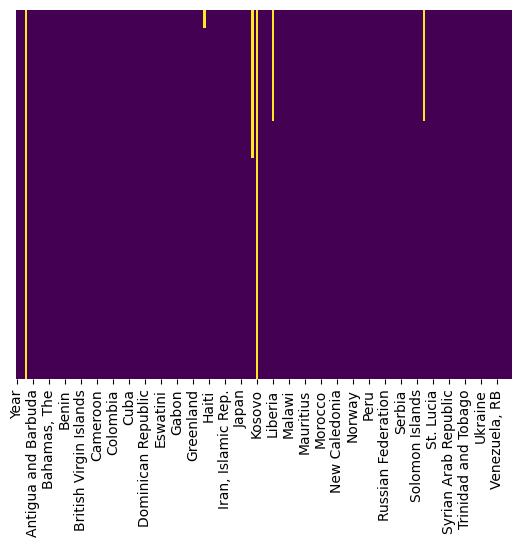

In [4]:
sns.heatmap(df_electricity.isnull(), yticklabels=False, cbar=False, cmap='viridis')

In [5]:
country_to_region = dict(zip(df_regions["CountryName"], df_regions["Region"]))

def fill_missing_with_regional(electricity_df,x):
    # แปลง Wide Format เป็น Long Format
    long_df = electricity_df.melt(id_vars=["Year"], var_name="Country", value_name="val")

    # เพิ่มคอลัมน์ Region โดยใช้ Mapping ที่สร้างไว้ล่วงหน้า
    long_df["Region"] = long_df["Country"].map(country_to_region)

    if x == "mean":
        regional = long_df.groupby(["Year", "Region"])["val"].mean()
    elif x == "median":
        regional = long_df.groupby(["Year", "Region"])["val"].median()

    # ฟังก์ชันเติมค่าที่หายไป
    def fill_missing_values(row):
        if pd.isna(row["val"]) and row["Region"] in regional.index.get_level_values("Region"):
            return regional.loc[(row["Year"], row["Region"])]  # ใช้ Median แทน Mean
        return row["val"]

    # เติมค่าที่หายไปใน Long Format
    long_df["val"] = long_df.apply(fill_missing_values, axis=1)

    # แปลงกลับเป็น Wide Format
    electricity_filled_df = long_df.pivot(index="Year", columns="Country", values="val").reset_index()

    return electricity_filled_df

In [6]:
# Electricity
df_electricity = fill_missing_with_regional(df_electricity,"median")

# GDP
df_gdp.fillna(df_gdp.interpolate(method='linear'), inplace=True)
df_gdp.fillna(df_gdp.interpolate(method='linear', limit_direction='backward'), inplace=True)
df_gdp.dropna(axis=1, inplace=True)

# Broadband Subscriptions
df_internet.interpolate(method='linear', axis=0, inplace=True)
df_internet.bfill(inplace=True)
df_internet.dropna(axis=1, inplace=True)

# Hospital Beds
df_hospital = fill_missing_with_regional(df_hospital,"mean")

# Life Expectancy
df_life_expectancy["Curacao"].fillna(df_life_expectancy["Curacao"].interpolate(method='linear'), inplace=True)
df_life_expectancy.dropna(axis=1, inplace=True)

### Check missing value

<Axes: xlabel='Country'>

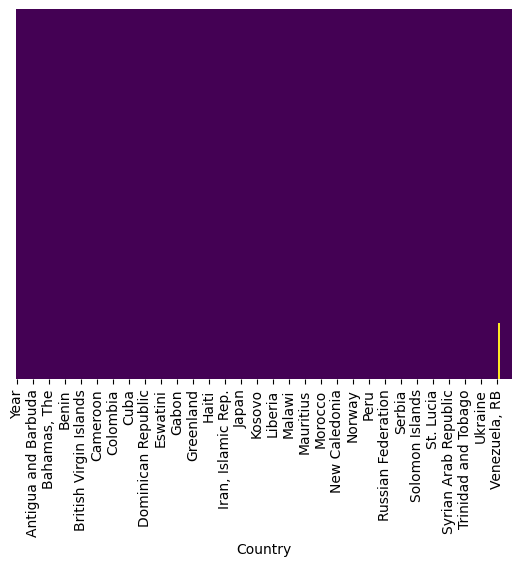

In [7]:
sns.heatmap(df_hospital.isnull(), yticklabels=False, cbar=False, cmap='viridis')

In [8]:
df_hospital.head(20)

Country,Year,Afghanistan,Albania,Algeria,American Samoa,Andorra,Angola,Antigua and Barbuda,Argentina,Armenia,...,Uruguay,Uzbekistan,Vanuatu,"Venezuela, RB",Viet Nam,Virgin Islands (U.S.),West Bank and Gaza,"Yemen, Rep.",Zambia,Zimbabwe
0,2001,0.39,3.17,1.760000,3.605000,2.520000,1.690000,2.600000,2.144286,5.16,...,2.144286,5.55,3.100000,0.800000,1.41,2.886923,2.225000,0.590000,1.690000,1.690000
1,2002,0.39,3.10,1.750000,3.880000,3.460000,1.784286,2.300000,1.857500,4.50,...,1.857500,5.75,3.880000,1.857500,1.42,3.036667,2.221333,0.590000,1.784286,1.784286
2,2003,0.39,3.08,1.780000,2.977500,3.150000,1.952667,2.500000,1.490000,4.61,...,1.900000,5.66,3.700000,0.900000,1.44,3.067368,2.224667,0.590000,1.952667,1.952667
3,2004,0.39,3.07,1.810000,2.700000,2.680000,1.759524,2.400000,1.565714,4.65,...,1.565714,5.45,2.700000,1.565714,1.51,2.990000,2.186000,0.590000,2.000000,1.759524
4,2005,0.42,3.06,1.458462,2.460000,2.580000,0.800000,2.400000,4.000000,4.71,...,1.040000,5.36,4.100000,2.008750,1.53,2.676190,2.090000,0.610000,1.458462,1.458462
5,2006,0.42,3.11,1.720000,3.767500,2.570000,1.638529,2.400000,1.764444,4.72,...,0.990000,5.33,3.767500,1.764444,1.57,2.361333,2.109333,0.660000,1.638529,3.000000
6,2007,0.42,3.09,1.658889,2.860000,2.750000,1.658889,2.000000,1.597273,4.37,...,0.980000,5.08,2.860000,1.300000,1.68,2.030500,1.998000,0.640000,1.658889,1.658889
7,2008,0.42,3.08,1.750000,2.460000,2.810000,1.526190,1.700000,1.547143,4.14,...,0.950000,4.96,1.680000,1.547143,1.77,2.452778,1.973333,0.630000,1.900000,1.526190
8,2009,0.42,3.00,1.750000,2.960000,2.500000,1.522917,2.200000,1.662000,4.07,...,1.100000,4.96,2.960000,1.100000,1.90,2.378000,1.930667,0.650000,1.522917,1.880000
9,2010,0.43,2.99,1.720000,3.058750,6.123571,1.571250,2.200000,4.500000,4.13,...,2.580000,4.88,3.058750,2.117000,2.02,2.261500,1.926667,0.650000,2.000000,1.850000


### Convert Dataframe into CSV File

In [9]:
df_electricity.to_csv(os.path.join(processed_data_path, "electricity.csv"), index=False)
df_internet.to_csv(os.path.join(processed_data_path, "internet.csv"), index=False)
df_hospital.to_csv(os.path.join(processed_data_path, "hospital.csv"), index=False)
df_gdp.to_csv(os.path.join(processed_data_path, "gdp.csv"), index=False)
df_pop_working_age.to_csv(os.path.join(processed_data_path, "pop_working_age.csv"), index=False)
df_life_expectancy.to_csv(os.path.join(processed_data_path, "life_expectancy.csv"), index=False)